In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

In [56]:
imdb = pd.read_csv("IMDb Movies India.csv", encoding = "ISO-8859-1")
imdb

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali
...,...,...,...,...,...,...,...,...,...,...
15504,Zulm Ko Jala Doonga,(1988),NaN,Action,4.6,11,Mahendra Shah,Naseeruddin Shah,Sumeet Saigal,Suparna Anand
15505,Zulmi,(1999),129 min,"Action, Drama",4.5,655,Kuku Kohli,Akshay Kumar,Twinkle Khanna,Aruna Irani
15506,Zulmi Raj,(2005),NaN,Action,NaN,NaN,Kiran Thej,Sangeeta Tiwari,NaN,NaN
15507,Zulmi Shikari,(1988),NaN,Action,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


In [58]:
#Look at the total number of unique values within the dataset
for column in imdb.columns:
    print(f'{column} has {imdb[column].nunique()} unique values')

Name has 13838 unique values
Year has 102 unique values
Duration has 182 unique values
Genre has 485 unique values
Rating has 84 unique values
Votes has 2034 unique values
Director has 5938 unique values
Actor 1 has 4718 unique values
Actor 2 has 4891 unique values
Actor 3 has 4820 unique values


In [59]:
#convert duration into numeric and then convert to seconds
imdb['Votes'] = imdb['Votes'].apply(lambda x: x.replace(',', '') if isinstance(x, str) else x)
imdb['Votes'] = imdb['Votes'].apply(lambda x: float(x.replace('$', '').replace('M', '')) * 1e6 if isinstance(x, str) and 'M' in x else x)
imdb['Votes'] = pd.to_numeric(imdb['Votes'])
imdb['Votes'] = imdb['Votes'].astype('Int64')

In [60]:
#convert the data types for the neccessary columns for easier analysis
#for year remove the brackets first
imdb['Year'] = imdb['Year'].str.extract(r'(\d+)')
#Convert year to numeric
imdb['Year'] = pd.to_numeric(imdb['Year'], errors = 'coerce')
imdb['Year'] = imdb['Year'].astype('Int64') 


In [61]:
# Extract only the numeric part of the duration and convert it to integer
imdb['Duration'] = imdb['Duration'].str.extract(r'(\d+)').astype(float).astype('Int64')
#rename the column to identify it to be in minutes
imdb.rename(columns={'Duration': 'Duration(Min)'}, inplace=True)
#Create a new column for the duration in seconds
imdb['Duration(Sec)'] = imdb['Duration(Min)'] * 60
#display the dataframe to show that the changes have been made
imdb.head(10)

,Name,Year,Duration(Min),Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Duration(Sec)
0,,<NA>,<NA>,Drama,NaN,<NA>,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia,<NA>
1,#Gadhvi (He thought he was Gandhi),2019,109,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid,6540
2,#Homecoming,2021,90,"Drama, Musical",NaN,<NA>,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana,5400
3,#Yaaram,2019,110,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor,6600
4,...And Once Again,2010,105,Drama,NaN,<NA>,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali,6300
5,...Aur Pyaar Ho Gaya,1997,147,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor,8820
6,...Yahaan,2005,142,"Drama, Romance, War",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma,8520
7,.in for Motion,2008,59,Documentary,NaN,<NA>,Anirban Datta,NaN,NaN,NaN,3540
8,?: A Question Mark,2012,82,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia,4920
9,@Andheri,2014,116,"Action, Crime, Thriller",4.0,11,Biju Bhaskar Nair,Augustine,Fathima Babu,Byon,6960


In [62]:
imdb['Genre'] = imdb['Genre'].str.split(', ')
imdb.head(10)

,Name,Year,Duration(Min),Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Duration(Sec)
0,,<NA>,<NA>,[Drama],NaN,<NA>,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia,<NA>
1,#Gadhvi (He thought he was Gandhi),2019,109,[Drama],7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid,6540
2,#Homecoming,2021,90,"[Drama, Musical]",NaN,<NA>,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana,5400
3,#Yaaram,2019,110,"[Comedy, Romance]",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor,6600
4,...And Once Again,2010,105,[Drama],NaN,<NA>,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali,6300
5,...Aur Pyaar Ho Gaya,1997,147,"[Comedy, Drama, Musical]",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor,8820
6,...Yahaan,2005,142,"[Drama, Romance, War]",7.4,1086,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma,8520
7,.in for Motion,2008,59,[Documentary],NaN,<NA>,Anirban Datta,NaN,NaN,NaN,3540
8,?: A Question Mark,2012,82,"[Horror, Mystery, Thriller]",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia,4920
9,@Andheri,2014,116,"[Action, Crime, Thriller]",4.0,11,Biju Bhaskar Nair,Augustine,Fathima Babu,Byon,6960


In [63]:
imdb = imdb.explode('Genre')
imdb

,Name,Year,Duration(Min),Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Duration(Sec)
0,,<NA>,<NA>,Drama,NaN,<NA>,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia,<NA>
1,#Gadhvi (He thought he was Gandhi),2019,109,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid,6540
2,#Homecoming,2021,90,Drama,NaN,<NA>,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana,5400
2,#Homecoming,2021,90,Musical,NaN,<NA>,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana,5400
3,#Yaaram,2019,110,Comedy,4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor,6600
...,...,...,...,...,...,...,...,...,...,...,...
15505,Zulmi,1999,129,Drama,4.5,655,Kuku Kohli,Akshay Kumar,Twinkle Khanna,Aruna Irani,7740
15506,Zulmi Raj,2005,<NA>,Action,NaN,<NA>,Kiran Thej,Sangeeta Tiwari,NaN,NaN,<NA>
15507,Zulmi Shikari,1988,<NA>,Action,NaN,<NA>,NaN,NaN,NaN,NaN,<NA>
15508,Zulm-O-Sitam,1998,130,Action,6.2,20,K.C. Bokadia,Dharmendra,Jaya Prada,Arjun Sarja,7800


In [64]:
imdb.dtypes

Name              object
Year               Int64
Duration(Min)      Int64
Genre             object
Rating           float64
Votes              Int64
Director          object
Actor 1           object
Actor 2           object
Actor 3           object
Duration(Sec)      Int64
dtype: object

In [65]:
imdb['Duration(Min)'] = imdb['Duration(Min)'].astype('Float64')

In [66]:
#Drop unneccesaary columns
imdb = imdb.drop(columns=['Name', 'Year', 'Duration(Sec)'], axis = 1)

In [67]:
# Calculate percentage of null values for each column
null_percentage = imdb.isnull().sum() / len(imdb) * 100

# Format and display the results
null_percentage = null_percentage.sort_values(ascending=False)  # Optional: sort by percentage
print('The percentage of missing values per feature is as follows:','\n', null_percentage.round())


The percentage of missing values per feature is as follows: 
 Duration(Min)    43.0
Rating           37.0
Votes            37.0
Actor 3          14.0
Actor 2          11.0
Genre             8.0
Actor 1           7.0
Director          2.0
dtype: float64


In [68]:
#fill in the null values of the Ratings, Vote, and Duration(Min) with mean/median values
imdb['Duration(Min)'].fillna(imdb['Duration(Min)'].median(), inplace=True)
imdb['Votes'].fillna(imdb['Votes'].median(), inplace=True)
imdb['Rating'].fillna(imdb['Rating'].median(), inplace=True)
#Drop the null values in the categorical columns  
imdb = imdb.dropna(subset = ['Actor 1', 'Actor 2', 'Actor 3', 'Director'])

C:\Users\User\AppData\Local\Temp\ipykernel_23896\2205836067.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  imdb['Duration(Min)'].fillna(imdb['Duration(Min)'].median(), inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_23896\2205836067.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

In [69]:
imdb.dtypes

Duration(Min)    Float64
Genre             object
Rating           float64
Votes              Int64
Director          object
Actor 1           object
Actor 2           object
Actor 3           object
dtype: object

In [70]:
imdb

,Duration(Min),Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,135.0,Drama,6.0,89,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,109.0,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,90.0,Drama,6.0,89,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
2,90.0,Musical,6.0,89,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,110.0,Comedy,4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
...,...,...,...,...,...,...,...,...
15504,135.0,Action,4.6,11,Mahendra Shah,Naseeruddin Shah,Sumeet Saigal,Suparna Anand
15505,129.0,Action,4.5,655,Kuku Kohli,Akshay Kumar,Twinkle Khanna,Aruna Irani
15505,129.0,Drama,4.5,655,Kuku Kohli,Akshay Kumar,Twinkle Khanna,Aruna Irani
15508,130.0,Action,6.2,20,K.C. Bokadia,Dharmendra,Jaya Prada,Arjun Sarja


## DATA VISUALISATION

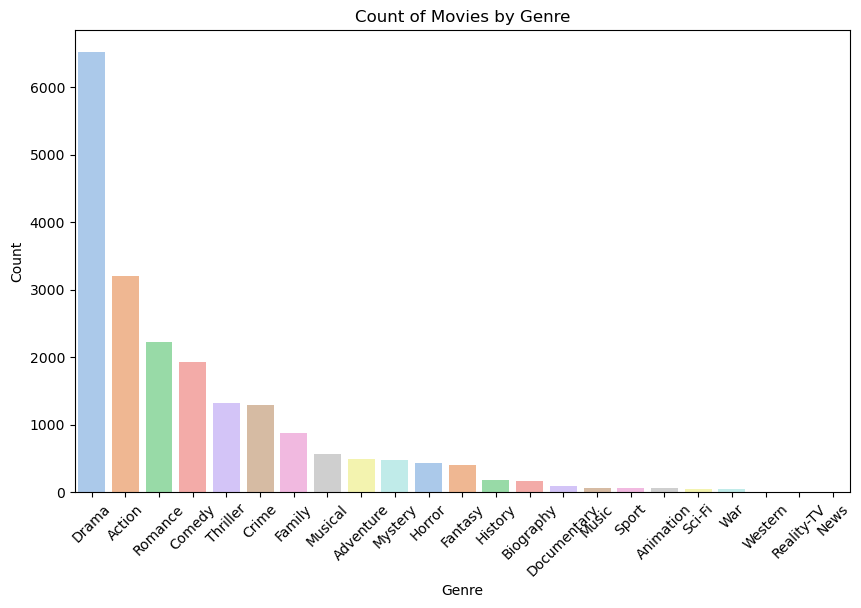

In [71]:
# Count of genres
plt.figure(figsize=(10, 6))
sns.countplot(data=imdb, x="Genre", palette="pastel", order=imdb["Genre"].value_counts().index)
plt.title("Count of Movies by Genre")
plt.xlabel("Genre")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()

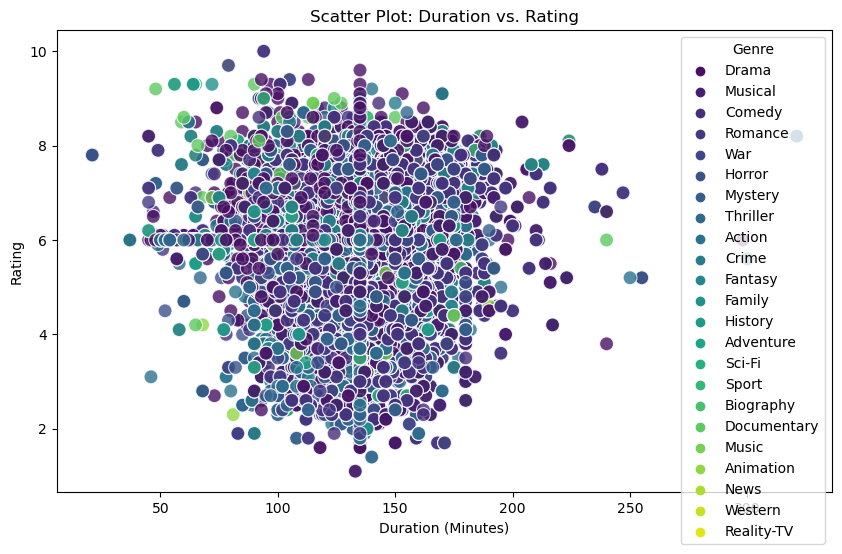

In [72]:
# Scatter Plot: Duration vs. Rating with Genre as Hue
plt.figure(figsize=(10, 6))
sns.scatterplot(data=imdb, x="Duration(Min)", y="Rating", hue="Genre", palette="viridis", s=100, alpha=0.8)
plt.title("Scatter Plot: Duration vs. Rating")
plt.xlabel("Duration (Minutes)")
plt.ylabel("Rating")
plt.legend(title="Genre")
plt.show()

c:\Users\User\.conda\envs\learn-env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


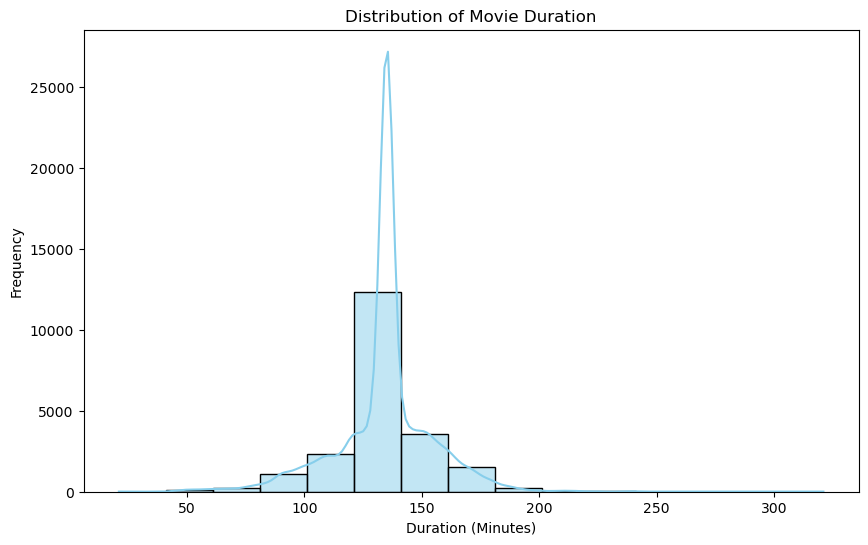

In [73]:
# Distribution of Duration
plt.figure(figsize=(10, 6))
sns.histplot(data=imdb, x="Duration(Min)", kde=True, color="skyblue", bins=15)
plt.title("Distribution of Movie Duration")
plt.xlabel("Duration (Minutes)")
plt.ylabel("Frequency")
plt.show()

### MODELLING AND MODEL EVALUATION
#### MODELLING
Here we are going to look at several models which include
- Linear Regression
- Ridge Regression
- Lasso Regression
- Random Forest Regression

#### MODEL EVALUATION
After creating the models look at the metrics to find a criteria we can use to measure success
Some of the metrics we will look at include:


In [74]:
#scale the numerical columns above
scaler= StandardScaler()
imdb[['Duration(Min)', 'Votes']] = scaler.fit_transform(imdb[['Duration(Min)', 'Votes']])
# One Hot Encode the genres column
genres = pd.get_dummies(imdb['Genre'], prefix='Genre')
#Add the genres to the dataframe
imdb=pd.concat([imdb, genres], axis=1)
#Drop the Genres colum since it won't be needed anymore
imdb.drop(columns=['Genre'], inplace=True)
#Target encode the other object data type columns
imdb['Director'] = imdb['Director'].map(imdb.groupby('Director')['Rating'].mean())
imdb['Actor 1'] = imdb['Actor 1'].map(imdb.groupby('Actor 1')['Rating'].mean())
imdb['Actor 2'] = imdb['Actor 2'].map(imdb.groupby("Actor 2")['Rating'].mean())
imdb['Actor 3'] = imdb['Actor 3'].map(imdb.groupby('Actor 3')['Rating'].mean())

In [75]:
#Split the data into test and train sets using the train testsplit
#Assign the target and feature values
X=imdb.drop(columns=['Rating'])#Features
y =imdb['Rating']#target
#Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [76]:
#Create a linear Regression model
#Create the regressor
lireg = LinearRegression()
#Fit into the train sets
lireg.fit(X_train, y_train)
#Make predictions of the model
lireg_predict = lireg.predict(X_test)

#Calculate and show the metrics
print('The metrics for the LInear Regression is as follows:','\n')

lireg_r2 = r2_score(y_test, lireg_predict)
print('The r2 score is:', '\t', lireg_r2, '\n')
lireg_mse = mean_squared_error(y_test, lireg_predict)
print('The Mean Squared Error is:', '\t', lireg_mse, '\n')
lireg_rmse = np.sqrt(lireg_mse)
print('The RMSE is:','\t', lireg_rmse, '\n' )
lireg_mae = mean_absolute_error(y_test, lireg_predict)
print('The Mean Absolute Error is:', '\t', lireg_mae, '\n')

The metrics for the LInear Regression is as follows: 

The r2 score is: 	 0.7120171589192912 

The Mean Squared Error is: 	 0.3978181741521946 

The RMSE is: 	 0.6307282886887147 

The Mean Absolute Error is: 	 0.44939096152908703 



In [77]:
#Perform a Ridge Regression
#iniatialize the regressor
l2 = Ridge()
#Fit onto the train and test data
l2.fit(X_train, y_train)
#make a prediction of the model
l2_predict = l2.predict(X_test)
#Make calculations and show the metrics
print('The metrics of the Ridge Regression as follows')
l2_r2 = r2_score(y_test, l2_predict)
print('The r2 score is:', '\t', l2_r2, '\n')
l2_mse = mean_squared_error(y_test, l2_predict)
print('The Mean Squared Error is:', '\t', l2_mse, '\n')
l2_rmse = np.sqrt(l2_mse)
print('The RMSE is:','\t', l2_rmse, '\n' )
l2_mae = mean_absolute_error(y_test, l2_predict)
print('The Mean Absolute Error is:', '\t', l2_mae, '\n')

The metrics of the Ridge Regression as follows
The r2 score is: 	 0.7120207255371801 

The Mean Squared Error is: 	 0.397813247242622 

The RMSE is: 	 0.6307243829460075 

The Mean Absolute Error is: 	 0.4493497018298829 



In [78]:
#Perform a Lasso Regression
#iniatialize the regressor
l1 = Lasso()
#Fit onto the train and test data
l1.fit(X_train, y_train)
#make a prediction of the model
l1_predict = l1.predict(X_test)
#Make calculations and show the metrics
print('The metrics of the Lasso Regression as follows')
l1_r2 = r2_score(y_test, l1_predict)
print('The r2 score is:', '\t', l1_r2, '\n')
l1_mse = mean_squared_error(y_test, l1_predict)
print('The Mean Squared Error is:', '\t', l1_mse, '\n')
l1_rmse = np.sqrt(l1_mse)
print('The RMSE is:','\t', l1_rmse, '\n' )
l1_mae = mean_absolute_error(y_test, l1_predict)
print('The Mean Absolute Error is:', '\t', l1_mae, '\n')

The metrics of the Lasso Regression as follows
The r2 score is: 	 -9.931057958212364e-07 

The Mean Squared Error is: 	 1.3813967795263127 

The RMSE is: 	 1.1753283709356772 

The Mean Absolute Error is: 	 0.8504355265090696 



In [79]:
#instsantiate the regressor
dfr = RandomForestRegressor()
#Fit onto the train sets
dfr.fit(X_train, y_train)
#Make a prediction for the model
dfr_prediction = dfr.predict(X_test)
#Make calculations and show the metrics success
print('The metrics of the Random Forest Regression as follows')
dfr_r2 = r2_score(y_test, dfr_prediction)
print('The r2 score is:', '\t', dfr_r2, '\n')
dfr_mse = mean_squared_error(y_test, dfr_prediction)
print('The Mean Squared Error is:', '\t', dfr_mse, '\n')
dfr_rmse = np.sqrt(dfr_mse)
print('The RMSE is:','\t', dfr_rmse, '\n' )
dfr_mae = mean_absolute_error(y_test, dfr_prediction)
print('The Mean Absolute Error is:', '\t', dfr_mae, '\n')

The metrics of the Random Forest Regression as follows
The r2 score is: 	 0.8975818783523903 

The Mean Squared Error is: 	 0.1414799229046107 

The RMSE is: 	 0.37613816996498867 

The Mean Absolute Error is: 	 0.196313421691245 



### Summary of the Model Performance:

Here are the results for each regression model:

#### 1. **Linear Regression:**
   - **R² Score:** 0.71
   - **Mean Squared Error (MSE):** 0.398
   - **Root Mean Squared Error (RMSE):** 0.631
   - **Mean Absolute Error (MAE):** 0.449

#### 2. **Ridge Regression:**
   - **R² Score:** 0.71
   - **Mean Squared Error (MSE):** 0.398
   - **Root Mean Squared Error (RMSE):** 0.631
   - **Mean Absolute Error (MAE):** 0.449

#### 3. **Lasso Regression:**
   - **R² Score:** -9.93e-07 (close to 0)
   - **Mean Squared Error (MSE):** 1.381
   - **Root Mean Squared Error (RMSE):** 1.175
   - **Mean Absolute Error (MAE):** 0.850

#### 4. **Random Forest Regression:**
   - **R² Score:** 0.90
   - **Mean Squared Error (MSE):** 0.142
   - **Root Mean Squared Error (RMSE):** 0.377
   - **Mean Absolute Error (MAE):** 0.197

### **Interpretation of Results:**

#### 1. **Linear and Ridge Regression:**
   - Both Linear and Ridge regression performed similarly, with an **R² score of 0.71**. This suggests that approximately **71%** of the variance in the target (rating score) can be explained by the models.
   - The **MSE, RMSE, and MAE** values for both models are nearly identical, indicating that they have similar performance in terms of prediction accuracy.
   - The **RMSE** values of **0.631** are reasonable but not particularly low, meaning the models have some prediction error.

#### 2. **Lasso Regression:**
   - **Lasso Regression** performed poorly in comparison to the others. It has an **R² score close to zero (-9.93e-07)**, indicating that it barely explains any of the variance in the target variable.
   - The **MSE** and **RMSE** are significantly higher than the other models, with a **RMSE of 1.175**, which suggests substantial prediction error.
   - The **MAE** value is also much higher (**0.850**), indicating that Lasso’s predictions are less accurate than those of the other models.

#### 3. **Random Forest Regression:**
   - **Random Forest Regression** achieved the **best performance** with an **R² score of 0.90**, meaning it explains about **90%** of the variance in the rating scores. This is significantly higher than the other models.
   - The **MSE** and **RMSE** values for Random Forest are much lower (0.142 and 0.377, respectively), indicating better accuracy in predictions.
   - The **MAE** value is also the lowest (**0.197**), meaning the model has the smallest average prediction error.

### **Conclusion:**

Based on the evaluation metrics, **Random Forest Regression** is the best-suited model for predicting the movie rating score. It provides the highest **R² score** (0.90), which indicates that it explains the most variance in the target variable. Additionally, it has the lowest **MSE, RMSE,** and **MAE**, suggesting that it provides the most accurate and reliable predictions.

- **Linear and Ridge Regression** also performed well with a good **R² score of 0.71**, but **Random Forest** outperforms them in terms of error metrics.
- **Lasso Regression** should be avoided for this task, as it performed significantly worse than all other models.

Thus, if you are looking for the best performance and most accurate predictions for the movie ratings, **Random Forest Regression** is the model to use.